In [1]:
# standard packages used to handle files
import sys
import os 
import glob
import time

from tqdm import tqdm

# commonly used library for data manipulation
import pandas as pd

# numerical
import numpy as np

# handle images - opencv
import cv2

# machine learning library
import sklearn
import sklearn.preprocessing

# used to serialize python objects to disk and load them back to memory
import pickle

# plotting
import matplotlib.pyplot as plt

# helper functions
import helpers

# specific helper functions for feature extraction
import features

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import log_loss

from sklearn.metrics import confusion_matrix
import pylab as pl

# tell matplotlib that we plot in a notebook
%matplotlib notebook

%matplotlib inline

In [2]:
# Resize then Gausian Blurr the images

dataset_path = "./images/"

dataset_path_train = os.path.join(dataset_path, 'train')

def getImgPaths(data_folder):
    """Returns filepaths of all files contained in the given folder as strings."""
    return np.sort(glob.glob(os.path.join(data_folder, '*')))

folder_paths = glob.glob(os.path.join(dataset_path_train,'*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in folder_paths]))

train_paths = dict((label_string, getImgPaths(os.path.join(dataset_path_train, label_string)))
                   for label_string in label_strings)

for image_paths in train_paths.values():
    for image_path in tqdm(image_paths):
        image = cv2.imread(image_path)
        image = cv2.resize(image, (500, 500))
        image = cv2.GaussianBlur(image,(5,5),0)
        new_path = image_path.replace(image_path[:image_path.index("images")],"resize_gausian_" )
        cv2.imwrite(new_path, image)
        
        

100%|██████████| 383/383 [00:23<00:00, 16.48it/s]


In [3]:
# filepath constants, set these according to your workflow:

# where are your datasets:
dataset_path = './resize_gausian_images/'
# where do you want to save your features and other outputs:
output_path = './resize_gausian_output/'

In [4]:
# you don't have to change the paths here:

dataset_path_train = os.path.join(dataset_path, 'train')
dataset_path_test = os.path.join(dataset_path, 'test')

features_path = os.path.join(output_path, 'features')
features_path_train = os.path.join(features_path, 'train')
features_path_test = os.path.join(features_path, 'test')

prediction_path = os.path.join(output_path, 'predictions')

# filepatterns to write out features
filepattern_descriptor_train = os.path.join(features_path_train, 'train_features_{}.pkl')
filepattern_descriptor_test = os.path.join(features_path_test, 'test_features_{}.pkl')

# create paths in case they don't exist:
helpers.createPath(features_path)
helpers.createPath(features_path_train)
helpers.createPath(features_path_test)
helpers.createPath(prediction_path)

In [5]:
folder_paths = glob.glob(os.path.join(dataset_path_train,'*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in folder_paths]))
num_classes = label_strings.shape[0]

print("Amount of classes: ", num_classes)
print("\nLabels: \n", label_strings)

Amount of classes:  12

Labels: 
 ['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse'
 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']


In [6]:
train_paths = dict((label_string, helpers.getImgPaths(os.path.join(dataset_path_train, label_string))) 
                   for label_string in label_strings)

test_paths = helpers.getImgPaths(dataset_path_test)

In [7]:
# Add all features which you would like to see computed and their callbacks to this dictionary
# Features where a pickle file already exists will not be recomputed

descriptor_dict = {
    'daisy': features.extractDAISYCallback, # SIFT replacement, very fast, can be computed dense if necessary
#     'orb': features.extractORBCallback, # another fast SIFT replacement, oriented BRIEF w. FAST keypoints  
#     'freak': features.extractFREAKCallback, # biologically motivated descriptor
#     'lucid': features.extractLUCIDCallback,  
#     'vgg': features.extractVGGCallback, # Trained as proposed by VGG lab, don't confuse it with VGG-Net features
#     'boost_desc': features.extractBoostDescCallback, # Image descriptor learned with boosting
    'sift': features.extractSIFTCallback # One descriptor to rule them all
}

In [8]:
train_descriptor_dict = descriptor_dict.copy()

# if the corresponding files already exist, do not extract them again
train_descriptor_dict = dict(
    (key, value) for (key, value) in descriptor_dict.items() 
    if not os.path.isfile(filepattern_descriptor_train.format(key))
)

if len(train_descriptor_dict) > 0:
    train_features = []
    train_labels = []
    
    # convert train images
    train_features_by_descriptor = dict((key, []) for (key,value) in train_descriptor_dict.items())
    
    for label_string in label_strings:
        print('Extracting train features for class {} :'.format(label_string))

        extracted_features = features.extractFeatures(train_paths[label_string], train_descriptor_dict, label_string)

        # append descriptors of corresponding label to correct descriptor list 
        for key in train_features_by_descriptor.keys():
            train_features_by_descriptor[key] += extracted_features[key]
  
    for descriptor_key in train_features_by_descriptor.keys():
        with open(filepattern_descriptor_train.format(descriptor_key), 'wb') as pkl_file_train:
            pickle.dump(train_features_by_descriptor[descriptor_key], pkl_file_train, protocol=pickle.HIGHEST_PROTOCOL)

Extracting train features for class chicken :


100%|██████████| 550/550 [01:50<00:00,  4.97it/s]

Extracting train features for class elephant :



100%|██████████| 435/435 [01:15<00:00,  5.73it/s]

Extracting train features for class fox :



100%|██████████| 249/249 [00:39<00:00,  6.37it/s]

Extracting train features for class german_shepherd :



100%|██████████| 462/462 [01:09<00:00,  6.63it/s]

Extracting train features for class golden_retriever :



100%|██████████| 75/75 [00:10<00:00,  6.96it/s]

Extracting train features for class horse :



100%|██████████| 466/466 [01:09<00:00,  6.73it/s]

Extracting train features for class jaguar :



100%|██████████| 87/87 [00:12<00:00,  6.76it/s]

Extracting train features for class lion :



100%|██████████| 394/394 [01:00<00:00,  6.51it/s]

Extracting train features for class owl :



100%|██████████| 321/321 [00:55<00:00,  5.76it/s]

Extracting train features for class parrot :



100%|██████████| 406/406 [01:04<00:00,  6.32it/s]

Extracting train features for class swan :



100%|██████████| 214/214 [00:31<00:00,  6.75it/s]

Extracting train features for class tiger :



100%|██████████| 383/383 [01:04<00:00,  5.89it/s]


In [9]:
def evaluate_models(X_train, X_valid, ytrain, yvalid, descriptor_desired):
    

    print('\n')
    
    #### SVM ####
    
    print(f" SVM ".center(40,'*'))

    # define support vector classifier
    model = SVC(kernel='linear',probability=True, random_state=42)

    # fit model
    model.fit(X_train, ytrain)
    
    display_metrics(X_train, X_valid, ytrain, yvalid, descriptor_desired, model,"SVM with resize and gausain blurr")
    
    
    #### Random Forest ####
    
    print(f" Random Forest ".center(40,'*'))
    
    # define Random Forest classifier
    model=RandomForestClassifier(n_estimators=100)
    
    # fit model
    model.fit(X_train, ytrain)
    
    display_metrics(X_train, X_valid, ytrain, yvalid, descriptor_desired, model,"Random Forest with resize and gausain blurr")
    


In [10]:
def display_metrics(X_train, X_valid, ytrain, yvalid, descriptor_desired, model, model_name):
    print(f'\nclassification accuracy for {model_name} ({descriptor_desired}): ' +repr(model.score(X_valid,yvalid)))
    print(f'training accuracy for {model_name} ({descriptor_desired}): ' +repr(model.score(X_train,ytrain))+"\n")


    #get confusion matrix
    predictions_abs = model.predict(X_valid)
    cm = confusion_matrix(yvalid, predictions_abs)

    #display matrix
    print(cm)


    # plot confusion matrix
    pl.matshow(cm)
    pl.title(f'Confusion matrix for {model_name} ({descriptor_desired})')
    pl.colorbar()
    pl.ylabel('True class label')
    pl.xlabel('Predicted class label')
    pl.show()   

    predictions_proba = model.predict_proba(X_valid)
    ll = log_loss(yvalid, predictions_proba)
    print('\n\nAverage Log Loss for ',model_name,' (', descriptor_desired, '): %.3f' %ll)

    print('\n')

In [11]:
descriptors = ['daisy','sift']

###################################  daisy  ####################################
Number of encoded train images: 4042
training took 908.3900408744812 seconds

Number of images for training : 3233
Number of images for validation : 809


***************** SVM ******************

classification accuracy for SVM with resize and gausain blurr (daisy): 0.484548825710754
training accuracy for SVM with resize and gausain blurr (daisy): 0.7868852459016393

[[79  9  3  8  0 10  0  6  3  9  2  2]
 [12 31  0  4  0 17  0  6  2  5  0  0]
 [ 8  3  6  6  0  2  0 16  3  4  4  3]
 [13  3  4 40  0 12  0  5  2  8  5  3]
 [ 4  2  5  3  0  1  0  2  0  3  2  0]
 [13  6  0  8  0 53  0  0  2  7  0  1]
 [ 0  0  0  0  0  0  4  4  1  1  0  2]
 [12  4  1  6  0  5  0 53  1  1  0  2]
 [ 5  0  1  1  0  3  1  3 17 13  3  5]
 [ 5  1  4  3  0  2  1  4  7 41  3  2]
 [ 3  0  2  4  0  2  0  0  0  9 22  1]
 [ 3  2  3  4  0  3  0  6  3  3  1 46]]


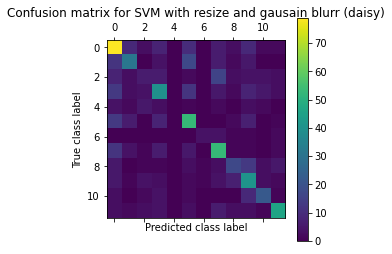



Average Log Loss for  SVM with resize and gausain blurr  ( daisy ): 1.599


************ Random Forest *************

classification accuracy for Random Forest with resize and gausain blurr (daisy): 0.37453646477132263
training accuracy for Random Forest with resize and gausain blurr (daisy): 1.0

[[58 12  2  8  0 16  0 12  3 11  3  6]
 [14 26  1  4  0 16  0  9  3  1  1  2]
 [16  4  1  8  0  4  0 13  1  4  3  1]
 [20  8  1 28  0 21  0  5  2  6  2  2]
 [ 5  2  2  4  0  4  0  0  0  1  3  1]
 [11 11  0  7  0 46  0  1  2  8  2  2]
 [ 2  0  0  0  0  0  0  2  2  0  0  6]
 [21  6  0  9  0  6  0 35  1  2  0  5]
 [ 7  2  0  2  0  3  0  1 15 14  0  8]
 [ 7  5  0  4  0  2  0  1  5 40  2  7]
 [ 4  0  0  3  0  3  0  0  0 12 20  1]
 [15  3  0  1  0  1  0  6  6  5  3 34]]


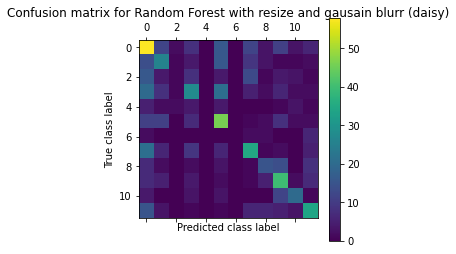



Average Log Loss for  Random Forest with resize and gausain blurr  ( daisy ): 2.070


####################################  sift  ####################################
Number of encoded train images: 4042
training took 699.2979898452759 seconds

Number of images for training : 3233
Number of images for validation : 809


***************** SVM ******************

classification accuracy for SVM with resize and gausain blurr (sift): 0.4264524103831891
training accuracy for SVM with resize and gausain blurr (sift): 0.8097742035261367

[[69 14  1 11  0 11  1  4  7  2  3  8]
 [10 26  0 10  0 15  0  5  4  4  1  2]
 [ 8  1 11  5  0  1  0  9  6  7  4  3]
 [19  4  1 30  0 15  0  7  4 12  0  3]
 [ 7  3  1  2  0  0  0  2  0  5  0  2]
 [ 9 15  1  8  0 43  0  3  0 10  0  1]
 [ 4  0  0  0  0  0  6  1  1  0  0  0]
 [ 7  8  3  7  0  3  0 50  3  2  0  2]
 [ 3  1  0  3  0  0  1  7 16 15  1  5]
 [ 7  2  0 12  0  6  0  5  5 25  3  8]
 [ 4  2  1  2  0  2  0  1  0  7 20  4]
 [ 5  2  0  1  0  1  0  8  3  5 

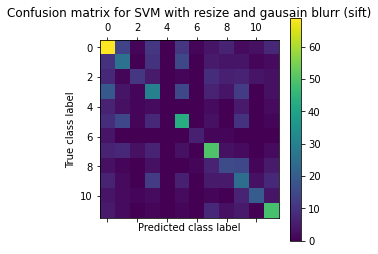



Average Log Loss for  SVM with resize and gausain blurr  ( sift ): 1.696


************ Random Forest *************

classification accuracy for Random Forest with resize and gausain blurr (sift): 0.30778739184178
training accuracy for Random Forest with resize and gausain blurr (sift): 1.0

[[60 17  1 10  0 19  1  9  3  3  0  8]
 [11 20  0  8  0 22  0  3  1  5  0  7]
 [12  4  2  9  0  3  0  3  4 12  1  5]
 [20 10  1 22  0 19  0 11  0  9  0  3]
 [ 7  1  0  2  0  3  0  0  2  3  0  4]
 [14 18  2 11  0 35  0  2  1  5  0  2]
 [ 4  0  0  0  0  0  6  1  0  0  0  1]
 [21  7  0 11  0  7  0 26  2  4  0  7]
 [12  3  0  6  0  3  1  6  5  8  0  8]
 [15  3  0 14  0 11  0  3  0 16  0 11]
 [ 6  5  0  3  0  5  0  0  0  9  8  7]
 [10  2  0  2  0  2  0  4  2  3  0 49]]


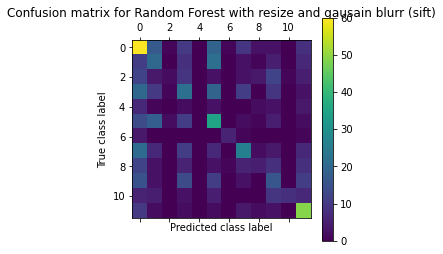



Average Log Loss for  Random Forest with resize and gausain blurr  ( sift ): 2.225




In [12]:
for descriptor_desired in descriptors:
    
    print(f'  {descriptor_desired}  '.center(80,'#'))
    
    with open(filepattern_descriptor_train.format(descriptor_desired), 'rb') as pkl_file_train:
        train_features_from_pkl = pickle.load(pkl_file_train)
    
    print('Number of encoded train images: {}'.format(len(train_features_from_pkl)))
        
    codebook_size = 1700

    clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=codebook_size)
    
    # encode all train images 
    train_data = []
    train_labels = []

    for image_features in train_features_from_pkl:
        bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
        train_data.append(bow_feature_vector)
        train_labels.append(image_features.label)
        

    # use a labelencoder to obtain numerical labels
    label_encoder = sklearn.preprocessing.LabelEncoder()
    label_encoder.fit(label_strings)
    train_labels = label_encoder.transform(train_labels)
    
    #Split Train Data for training and validations.
    X_train, X_valid, ytrain, yvalid = train_test_split(train_data, train_labels, test_size=0.2,random_state=42)
    print("\nNumber of images for training :",len(X_train))
    print("Number of images for validation :", len(X_valid))
    
    evaluate_models(X_train, X_valid, ytrain, yvalid, descriptor_desired)